In [1]:
%matplotlib inline
import gEconpy as ge
import gEconpy.plotting as gp

import matplotlib.pyplot as plt

In [2]:
def compare_steady_states(models, names):
    all_keys = set()
    for model in models:
        all_keys = all_keys.union(set(list(model.steady_state_dict.keys())))
    
    header = ' ' * 10 + ''.join([f'{name:>10}' for name in names])
    print(header)
    print('-' * len(header))

    for key in all_keys:
        line = f'{key:<10}'
        for model in models:
            if key in model.steady_state_dict.keys():
                value = f'{model.steady_state_dict[key]:>10.3f}'
            else:
                value = f'{"---":>10}'
            line += value 
        print(line)

# Baseline Model

In [3]:
rbc = ge.gEconModel('GCN Files/RBC_complete.gcn')

Model Building Complete.
Found:
	9 equations
	9 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	1 stochastic shock
		 1 / 1 have a defined prior. 
	6 parameters
		 4 / 6 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



In [4]:
rbc.steady_state()
rbc.solve_model()

Steady state found! Sum of squared residuals is 1.8273223312346094e-30
Solution found, sum of squared residuals:  1.0823547763477462e-30
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [5]:
rbc.print_steady_state()

A_ss               1.000
C_ss               2.358
I_ss               0.715
K_ss              35.732
L_ss               0.820
Y_ss               3.073
lambda_ss          0.276
r_ss               0.030
w_ss               2.436


# Impulse Response Function

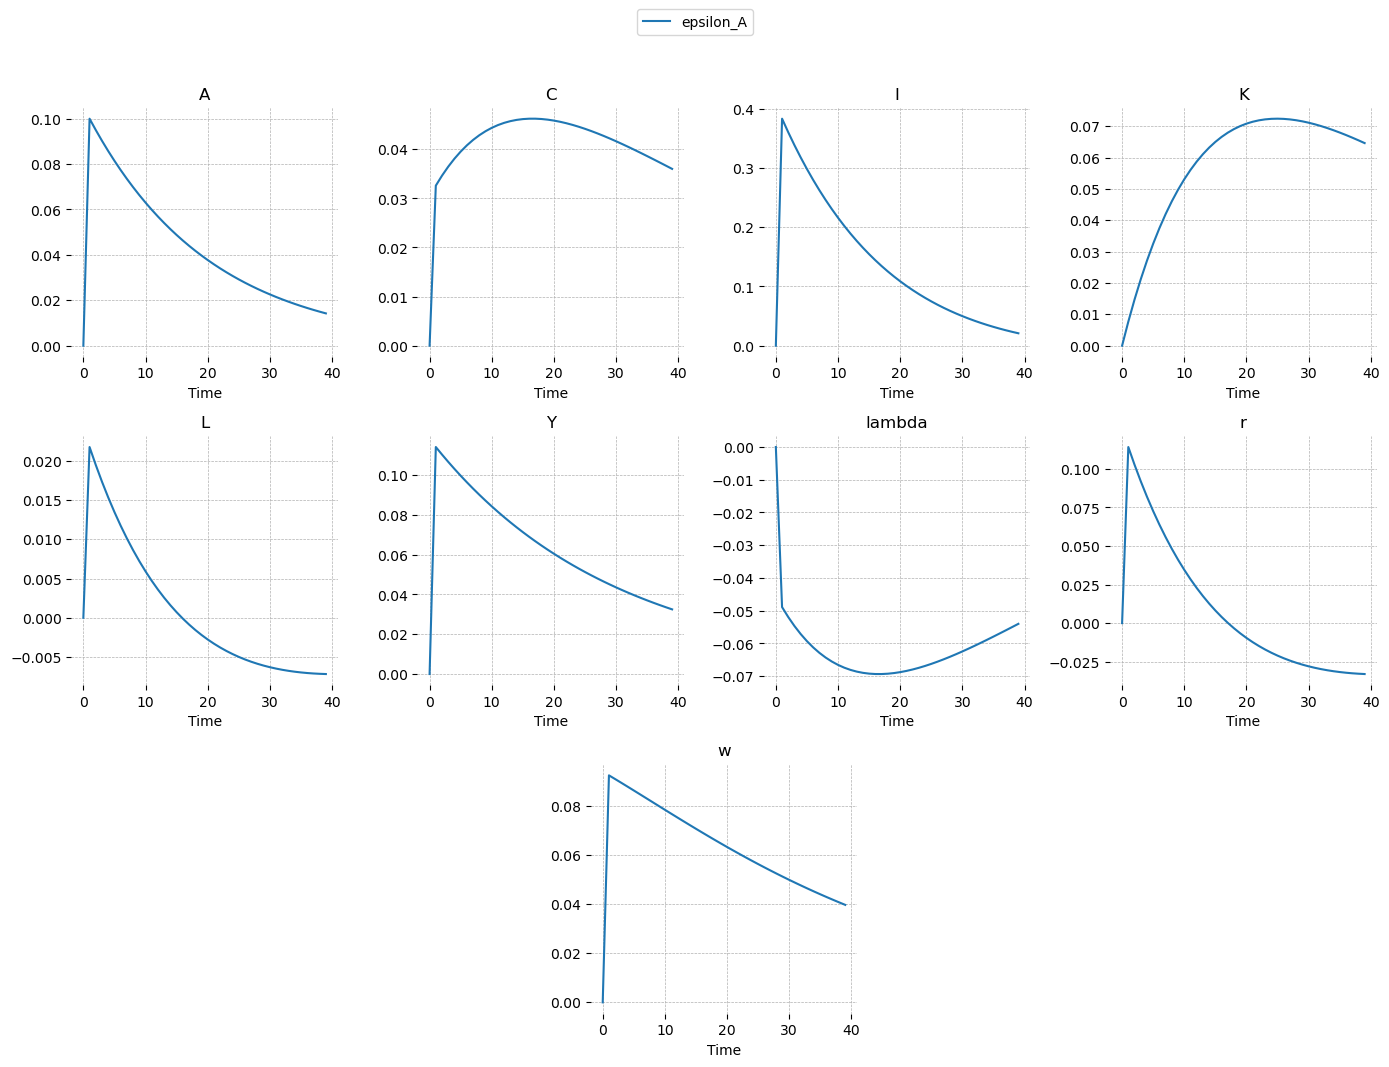

In [6]:
base_irf = rbc.impulse_response_function(simulation_length=40, shock_size=0.1)
gp.plot_irf(base_irf, legend=True);

In [7]:
rbc.check_bk_condition()

Model solution has 2 eigenvalues greater than one in modulus and 2 forward-looking variables.
Blanchard-Kahn condition is satisfied.


,Modulus,Real,Imaginary
0,1.252870e-35,-1.252870e-35,-0.0
1,1.951878e-18,-1.951878e-18,-0.0
2,9.500000e-01,9.500000e-01,0.0
3,9.697454e-01,9.697454e-01,0.0
4,1.041615e+00,1.041615e+00,0.0
5,5.077961e+06,5.077961e+06,0.0


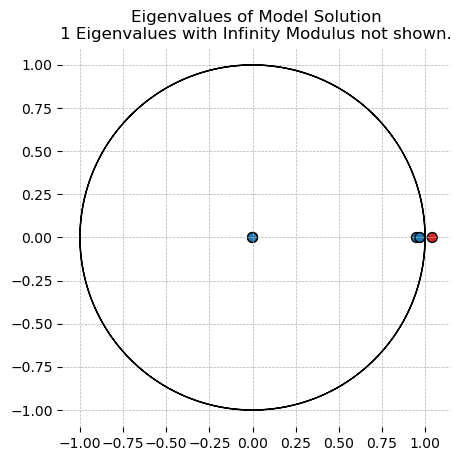

In [8]:
gp.plot_eigenvalues(rbc);

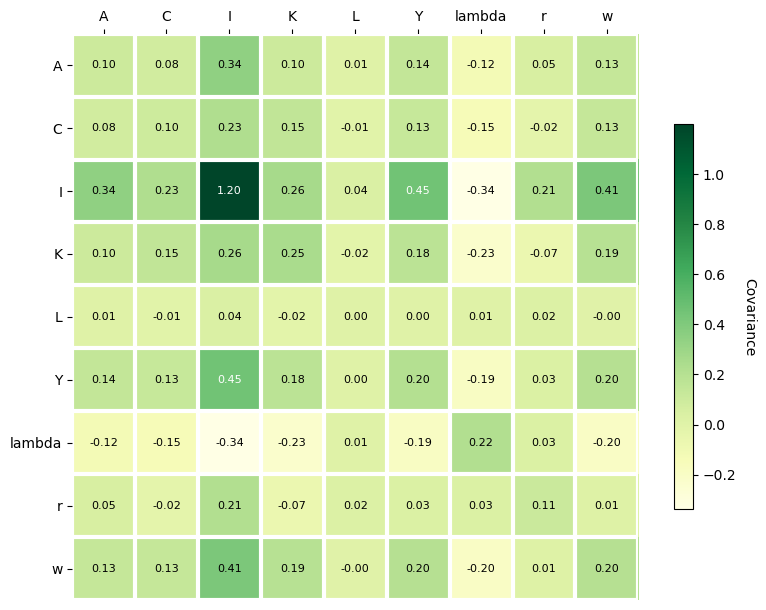

In [9]:
gp.plot_covariance_matrix(rbc.compute_stationary_covariance_matrix(), cbar_kw={'shrink':0.5});

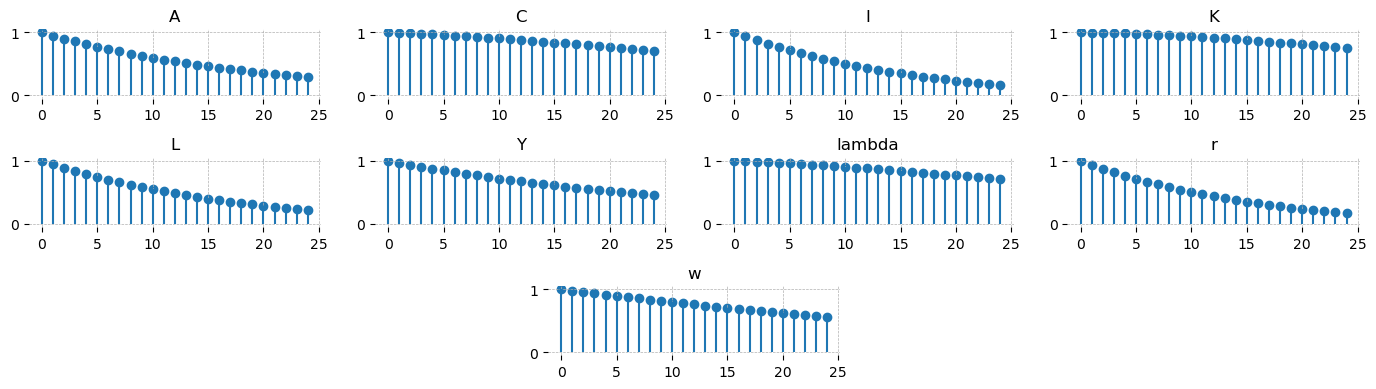

In [10]:
gp.plot_acf(rbc.compute_autocorrelation_matrix(n_lags=25));

# Extension 1: RBC with Capital Adjustment Cost

In [11]:
capital_adj = ge.gEconModel('GCN Files/RBC_w_capital_adj.gcn')

Model Building Complete.
Found:
	11 equations
	11 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	1 stochastic shock
		 1 / 1 have a defined prior. 
	7 parameters
		 4 / 7 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



## Using gEconpy to help do math

In [12]:
from gEconpy.shared.utilities import eq_to_ss
from gEconpy.classes.time_aware_symbol import TimeAwareSymbol
import sympy as sp

In [13]:
for i, eq in enumerate(capital_adj.system_equations):
    display(i, eq)
    print('-'*100)

0

-Q_t + lambda_t/q_t

----------------------------------------------------------------------------------------------------


1

-C_t - I_t + K_t-1*r_t + L_t*w_t

----------------------------------------------------------------------------------------------------


2

-1*phi*(-delta + I_t/K_t-1)**2*K_t-1/2 + I_t - K_t + K_t-1*(1 - delta)

----------------------------------------------------------------------------------------------------


3

-lambda_t + C_t**(-sigma_C)

----------------------------------------------------------------------------------------------------


4

-L_t**sigma_L + lambda_t*w_t

----------------------------------------------------------------------------------------------------


5

-lambda_t + q_t*(-phi*(-delta + I_t/K_t-1) + 1)

----------------------------------------------------------------------------------------------------


6

beta*(lambda_t+1*r_t+1 + q_t+1*(-delta + phi*I_t+1*(-delta + I_t+1/K_t)/K_t - phi*(-delta + I_t+1/K_t)**2/2 + 1)) - q_t

----------------------------------------------------------------------------------------------------


7

A_t*K_t-1**alpha*L_t**(1 - alpha) - Y_t

----------------------------------------------------------------------------------------------------


8

alpha*A_t*K_t-1**(alpha - 1)*L_t**(1 - alpha) - r_t

----------------------------------------------------------------------------------------------------


9

A_t*K_t-1**alpha*(1 - alpha)/L_t**alpha - w_t

----------------------------------------------------------------------------------------------------


10

rho_A*log(A_t-1) + epsilon_A_t - log(A_t)

----------------------------------------------------------------------------------------------------


In [14]:
eq = capital_adj.system_equations[2]
eq

-1*phi*(-delta + I_t/K_t-1)**2*K_t-1/2 + I_t - K_t + K_t-1*(1 - delta)

In [15]:
eq_ss = eq_to_ss(eq)
eq_ss

-phi*K_ss*(-delta + I_ss/K_ss)**2/2 + I_ss + K_ss*(1 - delta) - K_ss

In [16]:
I_ss = TimeAwareSymbol('I', 'ss')
I_ss

I_ss

There are two solutions for I_ss!

In [17]:
I_ss_solved = sp.solve(eq_ss, I_ss)
for x in I_ss_solved:
    display(x)

delta*K_ss

K_ss*(delta*phi + 2)/phi

In [18]:
eq2 = eq_to_ss(capital_adj.system_equations[5])
eq2

-lambda_ss + q_ss*(-phi*(-delta + I_ss/K_ss) + 1)

Depending on which one we choose, we either get $q_{ss} = \lambda_{ss}$, or $q_{ss} = -\lambda_{ss}$

In [19]:
q_ss = TimeAwareSymbol('q', 'ss')
q_ss_solved_1 = sp.solve(eq2.subs({I_ss:I_ss_solved[0]}), q_ss)[0]
q_ss_solved_1

lambda_ss

In [20]:
q_ss_solved_2 = sp.solve(eq2.subs({I_ss:I_ss_solved[1]}), q_ss)[0]
q_ss_solved_2

-lambda_ss

And depending on THAT choice, we end up with one of two expressions for the interest rate

In [21]:
eq3 = capital_adj.system_equations[6]
eq3

beta*(lambda_t+1*r_t+1 + q_t+1*(-delta + phi*I_t+1*(-delta + I_t+1/K_t)/K_t - phi*(-delta + I_t+1/K_t)**2/2 + 1)) - q_t

Choosing $I_{ss} = \delta K_{ss}$ leads to the usual expression for $r_{ss}$

In [22]:
r_ss = TimeAwareSymbol('r', 'ss')
sp.solve(eq_to_ss(eq3).subs({I_ss:I_ss_solved[0], q_ss:q_ss_solved_1}), r_ss)[0]

delta - 1 + 1/beta

While choosing $I_{ss} = (\frac{2}{\phi} + \delta)K_{ss}$ leads to a different formula.

**Question**: What does $\phi$ represent? Is this $r_{ss}$ higher or lower than the "usual" one?

In [23]:
sp.solve(eq_to_ss(eq3).subs({I_ss:I_ss_solved[1], q_ss:q_ss_solved_2}), r_ss)[0]

delta + 1 + 2/phi - 1/beta

## Solve Model

In [24]:
capital_adj.steady_state()
capital_adj.solve_model()

Steady state found! Sum of squared residuals is 1.8273223312346094e-30
Solution found, sum of squared residuals:  1.831805550351403e-30
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [25]:
compare_steady_states([rbc, capital_adj], ['Baseline', 'K Adj'])

            Baseline     K Adj
------------------------------
I_ss           0.715     0.715
r_ss           0.030     0.030
A_ss           1.000     1.000
Q_ss             ---     1.000
q_ss             ---     0.276
L_ss           0.820     0.820
K_ss          35.732    35.732
C_ss           2.358     2.358
lambda_ss      0.276     0.276
Y_ss           3.073     3.073
w_ss           2.436     2.436


## Covariance Matrix

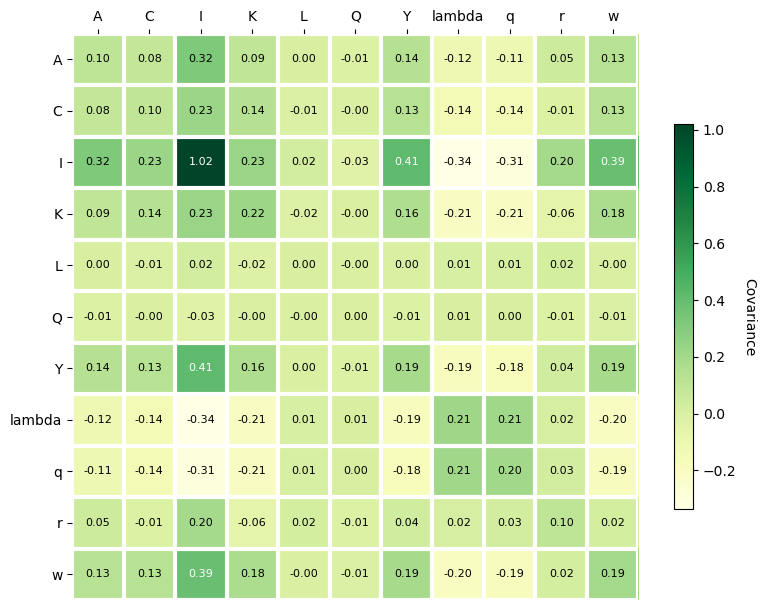

In [26]:
gp.plot_covariance_matrix(capital_adj.compute_stationary_covariance_matrix(), cbar_kw={'shrink':0.5});

## Autocorrelation Functions

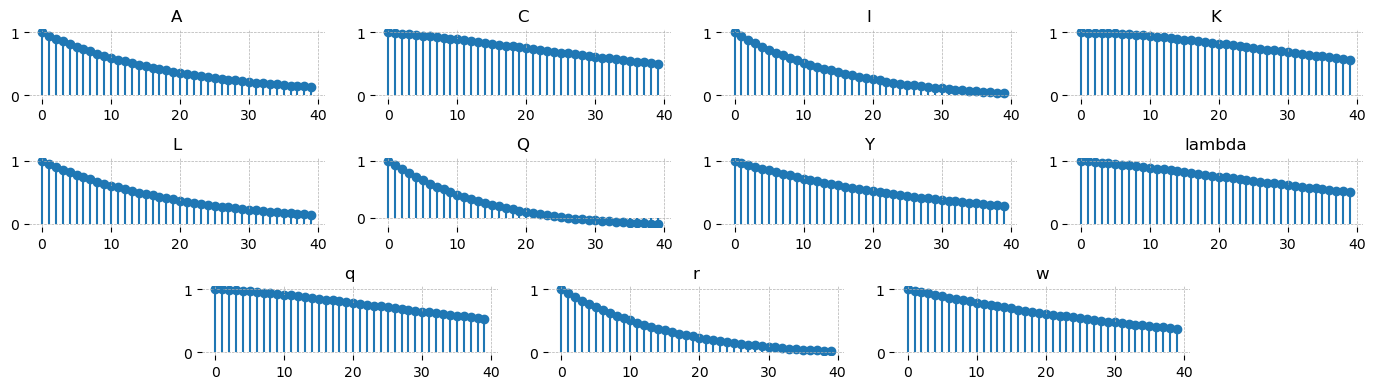

In [27]:
gp.plot_acf(capital_adj.compute_autocorrelation_matrix(n_lags=40));

## Compare Impulse Response Functions

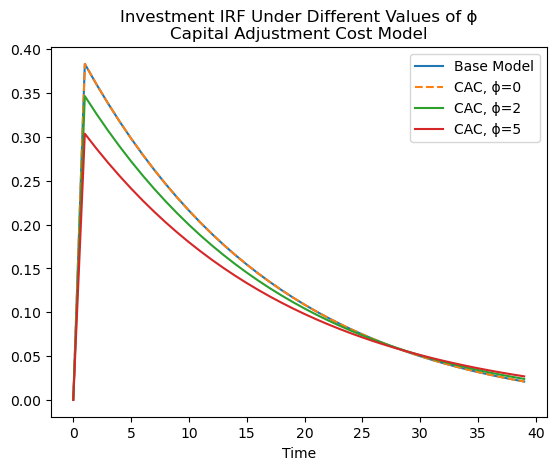

In [28]:
fig, ax = plt.subplots()

base_irf.loc['I'].droplevel(1).plot(label='Base Model', legend=True, ax=ax)
for ϕ in [0, 2, 5]:
    capital_adj.free_param_dict.update({'phi':ϕ})
    capital_adj.steady_state(verbose=False)
    capital_adj.solve_model(verbose=False)
    cap_adj_irf = capital_adj.impulse_response_function(simulation_length=40, shock_size=0.1)
    cap_adj_irf.loc['I'].droplevel(1).plot(label=f'CAC, ϕ={ϕ}', ls='--' if ϕ == 0 else '-', legend=True, ax=ax)
ax.set_title('Investment IRF Under Different Values of ϕ\nCapital Adjustment Cost Model')
plt.show()

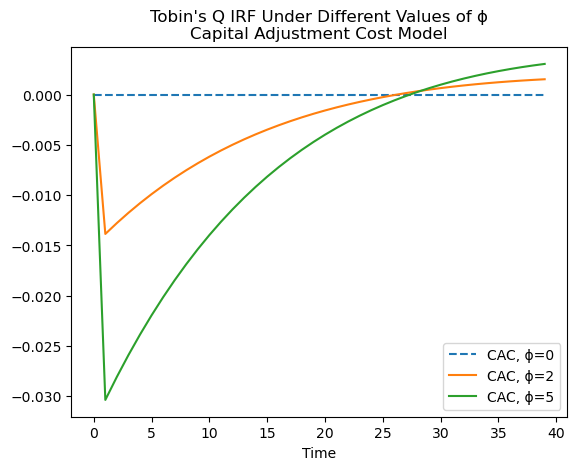

In [29]:
fig, ax = plt.subplots()

for ϕ in [0, 2, 5]:
    capital_adj.free_param_dict.update({'phi':ϕ})
    capital_adj.steady_state(verbose=False)
    capital_adj.solve_model(verbose=False)
    cap_adj_irf = capital_adj.impulse_response_function(simulation_length=40, shock_size=0.1)
    cap_adj_irf.loc['Q'].droplevel(1).plot(label=f'CAC, ϕ={ϕ}', ls='--' if ϕ == 0 else '-', legend=True)
ax.set_title("Tobin's Q IRF Under Different Values of ϕ\nCapital Adjustment Cost Model")
plt.show()

# Extension 2: Investment Adjustment Cost

In [30]:
inv_adj = ge.gEconModel('GCN Files/RBC_w_investment_adj.gcn')

Model Building Complete.
Found:
	11 equations
	11 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	1 stochastic shock
		 1 / 1 have a defined prior. 
	7 parameters
		 4 / 7 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



## Solve Model

In [31]:
inv_adj.steady_state()
inv_adj.solve_model()

Steady state found! Sum of squared residuals is 1.8273223312346094e-30
Solution found, sum of squared residuals:  8.550081770117816e-31
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [32]:
for eq in inv_adj.system_equations:
    display(eq)

-Q_t + lambda_t/q_t

-C_t - I_t + K_t-1*r_t + L_t*w_t

I_t*(1 - phi*(I_t/I_t-1 - 1*1)**2/2) - K_t + K_t-1*(1 - delta)

-lambda_t + C_t**(-sigma_C)

-L_t**sigma_L + lambda_t*w_t

beta*phi*I_t+1**2*q_t+1*(-1 + I_t+1/I_t)/I_t**2 - lambda_t + q_t*(-phi*I_t*(I_t/I_t-1 - 1)/I_t-1 - phi*(I_t/I_t-1 - 1*1)**2/2 + 1)

beta*(lambda_t+1*r_t+1 + q_t+1*(1 - delta)) - q_t

A_t*K_t-1**alpha*L_t**(1 - alpha) - Y_t

alpha*A_t*K_t-1**(alpha - 1)*L_t**(1 - alpha) - r_t

A_t*K_t-1**alpha*(1 - alpha)/L_t**alpha - w_t

rho_A*log(A_t-1) + epsilon_A_t - log(A_t)

In [33]:
compare_steady_states([rbc, inv_adj], ['Baseline', 'I Adj'])

            Baseline     I Adj
------------------------------
I_ss           0.715     0.715
r_ss           0.030     0.030
A_ss           1.000     1.000
Q_ss             ---     1.000
q_ss             ---     0.276
L_ss           0.820     0.820
K_ss          35.732    35.732
C_ss           2.358     2.358
lambda_ss      0.276     0.276
Y_ss           3.073     3.073
w_ss           2.436     2.436


## Covariance Matrix

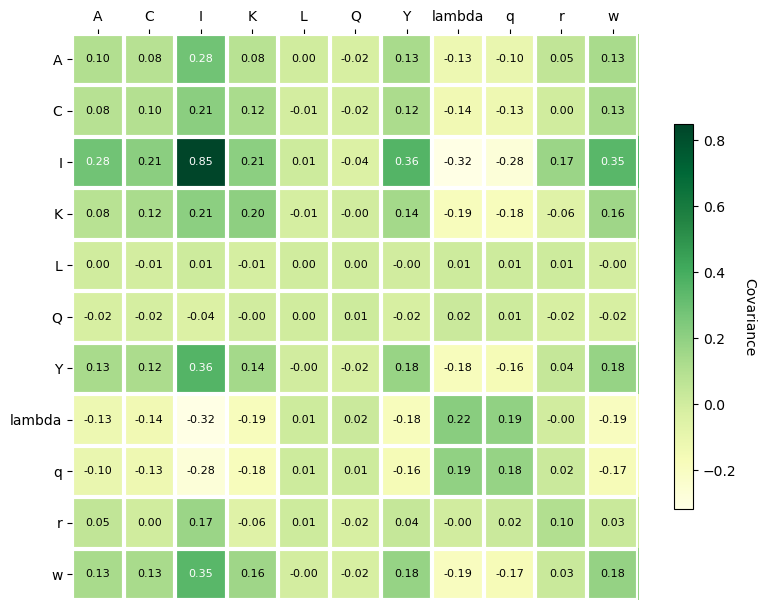

In [34]:
gp.plot_covariance_matrix(inv_adj.compute_stationary_covariance_matrix(), cbar_kw={'shrink':0.5});

## Autocorrelation Functions

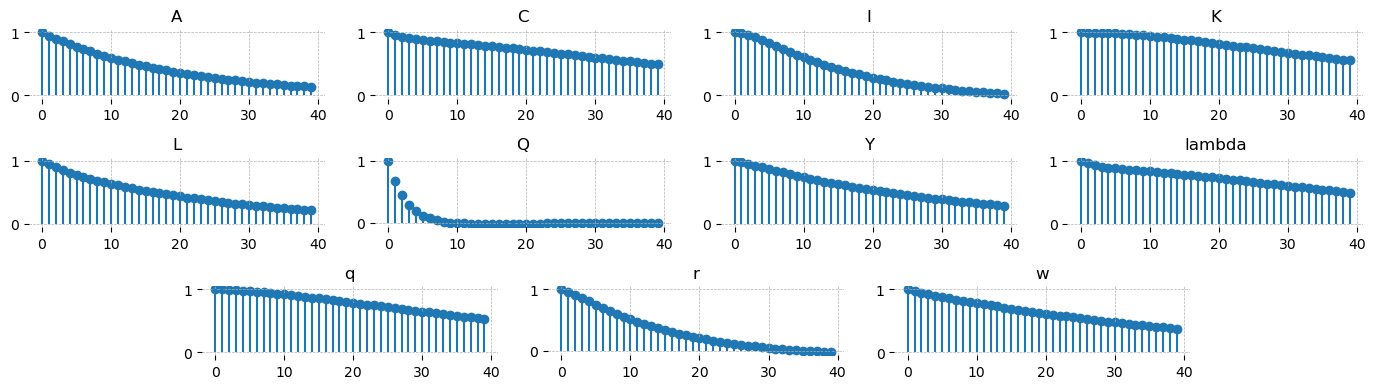

In [35]:
gp.plot_acf(inv_adj.compute_autocorrelation_matrix(n_lags=40));

## Impulse response Functions 

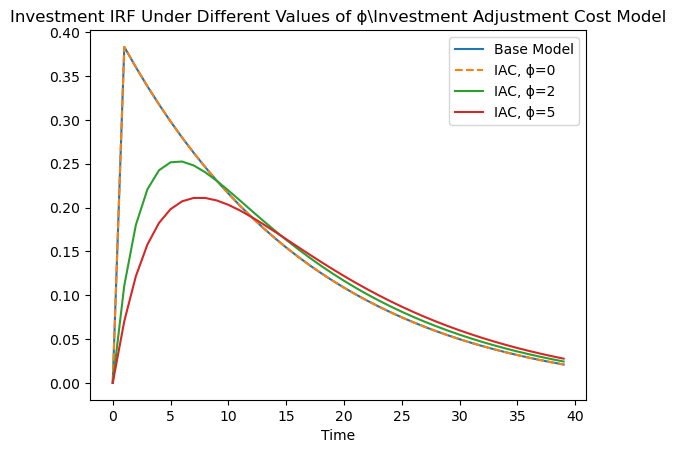

In [36]:
fig, ax = plt.subplots()

base_irf.loc['I'].droplevel(1).plot(label='Base Model', legend=True, ax=ax)
for ϕ in [0, 2, 5]:
    inv_adj.free_param_dict.update({'phi':ϕ})
    inv_adj.steady_state(verbose=False)
    inv_adj.solve_model(verbose=False)
    inv_adj_irf = inv_adj.impulse_response_function(simulation_length=40, shock_size=0.1)
    inv_adj_irf.loc['I'].droplevel(1).plot(label=f'IAC, ϕ={ϕ}', ls='--' if ϕ == 0 else '-', legend=True, ax=ax)
ax.set_title('Investment IRF Under Different Values of ϕ\Investment Adjustment Cost Model')
plt.show()

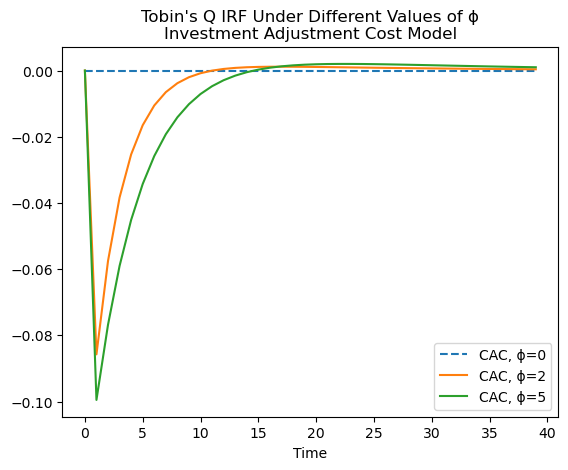

In [37]:
fig, ax = plt.subplots()

for ϕ in [0, 2, 5]:
    inv_adj.free_param_dict.update({'phi':ϕ})
    inv_adj.steady_state(verbose=False)
    inv_adj.solve_model(verbose=False)
    inv_adj_irf = inv_adj.impulse_response_function(simulation_length=40, shock_size=0.1)
    inv_adj_irf.loc['Q'].droplevel(1).plot(label=f'CAC, ϕ={ϕ}', ls='--' if ϕ == 0 else '-', legend=True)
ax.set_title("Tobin's Q IRF Under Different Values of ϕ\nInvestment Adjustment Cost Model")
plt.show()

# Extension 3: Bonds

In [38]:
bond_rbc = ge.gEconModel('GCN Files/RBC_w_bonds.gcn')

Model Building Complete.
Found:
	12 equations
	12 variables
	The following variables were eliminated at user request:
		U_t
	The following "variables" were defined as constants and have been substituted away:
		B_t,mc_t
	1 stochastic shock
		 1 / 1 have a defined prior. 
	6 parameters
		 4 / 6 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



In [39]:
bond_rbc.steady_state()
bond_rbc.solve_model(not_loglin_variable=['Div', 'TC'])

Steady state found! Sum of squared residuals is 1.830403819145629e-30
Solution found, sum of squared residuals:  8.651929639198767e-31
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [40]:
compare_steady_states([rbc, capital_adj, inv_adj, bond_rbc], ['Baseline', 'K_adj', 'I_adj', 'Bonds'])

            Baseline     K_adj     I_adj     Bonds
--------------------------------------------------
I_ss           0.715     0.715     0.715     0.715
r_ss           0.030     0.030     0.030     0.030
A_ss           1.000     1.000     1.000     1.000
Q_ss             ---     1.000     1.000       ---
r_G_ss           ---       ---       ---     1.010
TC_ss            ---       ---       ---    -3.073
q_ss             ---     0.276     0.276       ---
L_ss           0.820     0.820     0.820     0.820
K_ss          35.732    35.732    35.732    35.732
C_ss           2.358     2.358     2.358     2.358
lambda_ss      0.276     0.276     0.276     0.276
Y_ss           3.073     3.073     3.073     3.073
Div_ss           ---       ---       ---     0.000
w_ss           2.436     2.436     2.436     2.436


# Extension 4: Preference Shock

In [41]:
pref_shock = ge.gEconModel('GCN Files/RBC_two_shock.gcn')

Model Building Complete.
Found:
	10 equations
	10 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	2 stochastic shocks
		 1 / 2 have a defined prior. 
	7 parameters
		 4 / 7 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



In [42]:
pref_shock.steady_state()
pref_shock.solve_model()

Steady state found! Sum of squared residuals is 1.8273223312346094e-30
Solution found, sum of squared residuals:  4.438195994510854e-31
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


## R Matrix

In [43]:
pref_shock.R.round(3)

,epsilon_A,epsilon_B
A,1.000,0.000
B,0.000,1.000
C,0.326,0.361
I,3.832,-1.835
K,0.077,-0.037
L,0.217,-0.230
Y,1.141,-0.150
lambda,-0.489,0.459
r,1.141,-0.150
w,0.924,0.081


## Impulse Response Functions

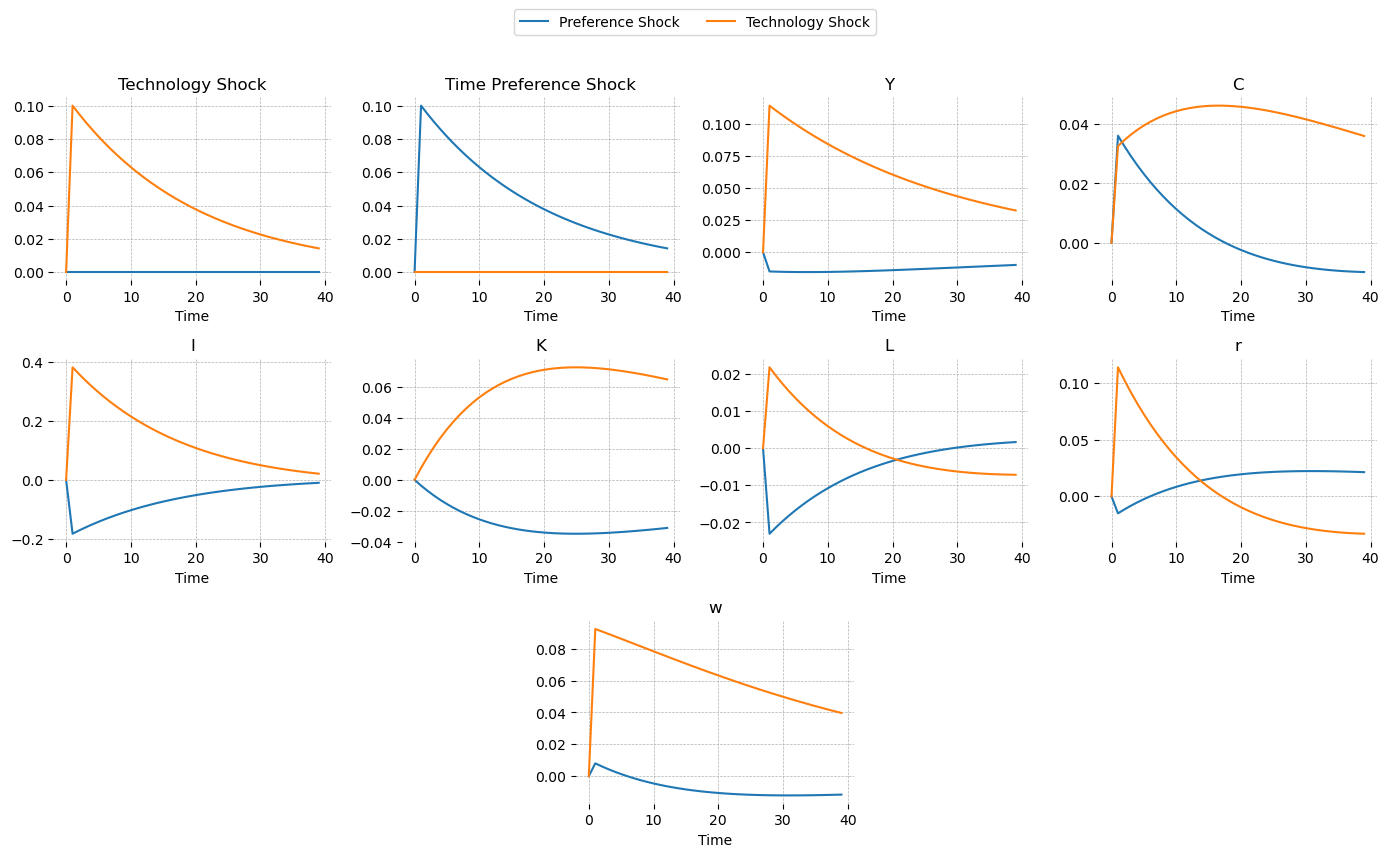

In [44]:
pref_irf = pref_shock.impulse_response_function(simulation_length=40, shock_size=0.1)
gp.plot_irf(pref_irf.rename(index={'A':'Technology Shock',
                                   'B':'Time Preference Shock'},
                            columns={'epsilon_A':'Technology Shock',
                                     'epsilon_B':'Preference Shock'}), 
            vars_to_plot=['Technology Shock', 'Time Preference Shock', 'Y', 'C', 'I', 'K', 'L',
                          'r', 'w'],
            figsize=(14,8),
            legend=True);

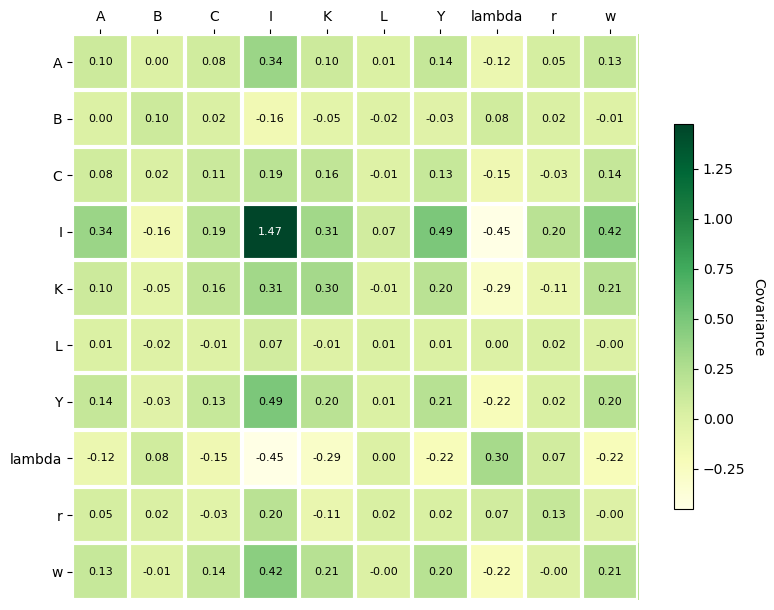

In [45]:
gp.plot_covariance_matrix(pref_shock.compute_stationary_covariance_matrix(), cbar_kw={'shrink':0.5});

## Autocorrelaion Functions

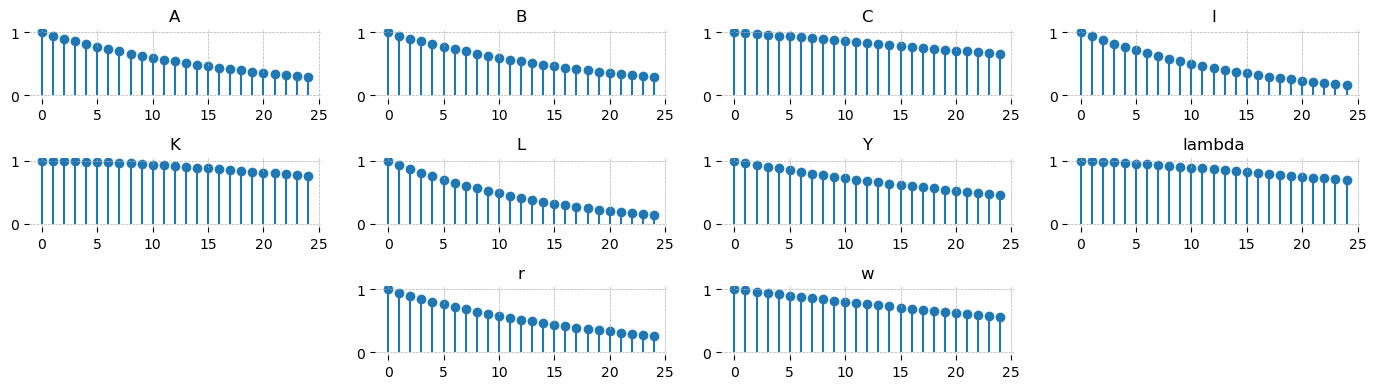

In [46]:
gp.plot_acf(pref_shock.compute_autocorrelation_matrix(n_lags=25));

# Extension 5: Three shocks: Technology, Preference, Investment Cost

In [47]:
three_shock = ge.gEconModel('GCN Files/RBC_three_shock.gcn')

Model Building Complete.
Found:
	12 equations
	12 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	3 stochastic shocks
		 1 / 3 have a defined prior. 
	10 parameters
		 4 / 10 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



In [48]:
three_shock.steady_state()
three_shock.solve_model()

Steady state found! Sum of squared residuals is 1.8273223312346094e-30
Solution found, sum of squared residuals:  5.179617245988481e-29
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [49]:
compare_steady_states([rbc, inv_adj, three_shock], ['Baseline', 'I Adj', '3 Shock'])

            Baseline     I Adj   3 Shock
----------------------------------------
I_ss           0.715     0.715     0.715
r_ss           0.030     0.030     0.030
A_ss           1.000     1.000     1.000
Z_ss             ---       ---     1.000
B_ss             ---       ---     1.000
Q_ss             ---     1.000       ---
q_ss             ---     0.276     0.276
L_ss           0.820     0.820     0.820
K_ss          35.732    35.732    35.732
C_ss           2.358     2.358     2.358
lambda_ss      0.276     0.276     0.276
Y_ss           3.073     3.073     3.073
w_ss           2.436     2.436     2.436


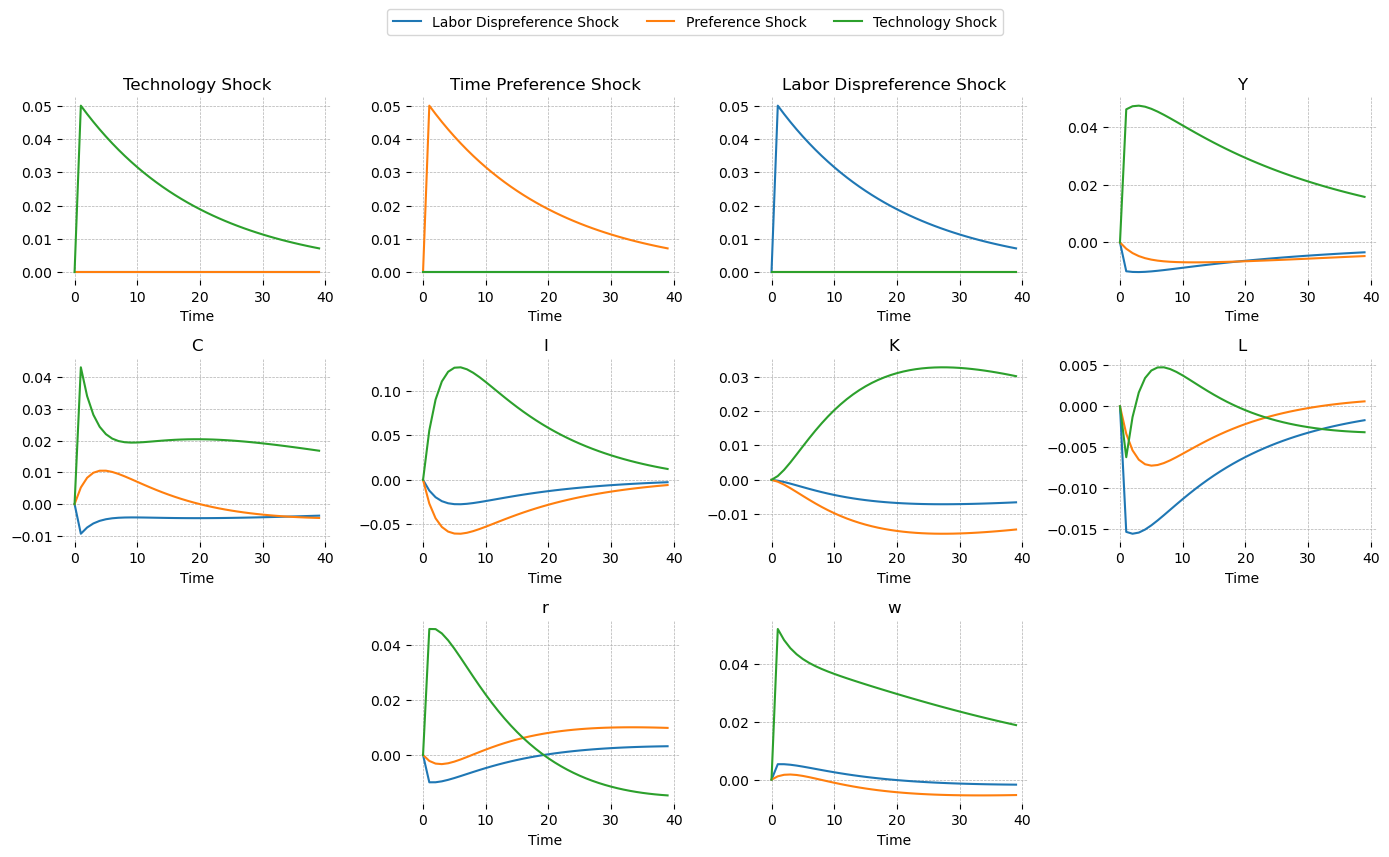

In [50]:
three_irf = three_shock.impulse_response_function(simulation_length=40, shock_size=0.05)

gp.plot_irf(three_irf.rename(index={'A':'Technology Shock',
                                   'B':'Time Preference Shock',
                                   'Z': 'Labor Dispreference Shock'},
                            columns={'epsilon_A':'Technology Shock',
                                     'epsilon_B':'Preference Shock',
                                     'epsilon_Z':'Labor Dispreference Shock'}), 
            vars_to_plot=['Technology Shock', 'Time Preference Shock', 'Labor Dispreference Shock',
                          'Y', 'C', 'I', 'K', 'L', 'r', 'w'],
            figsize=(14,8),
            legend=True);

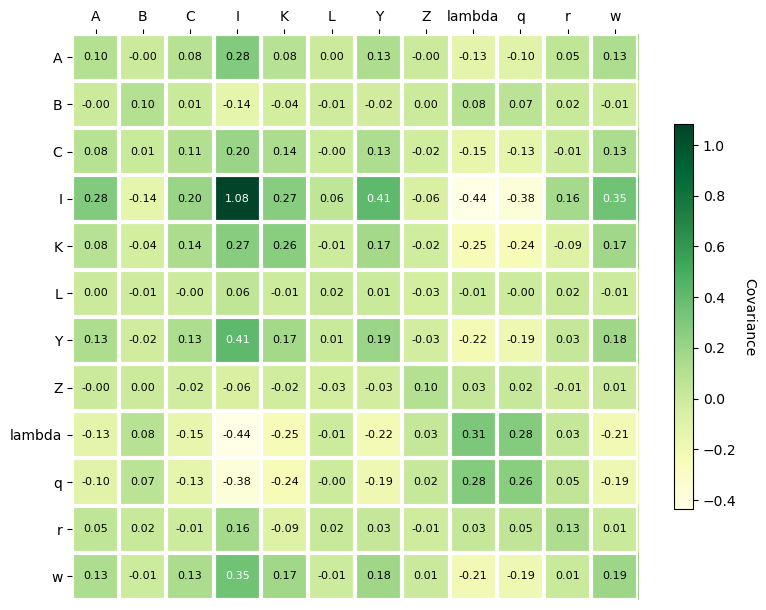

In [52]:
gp.plot_covariance_matrix(three_shock.compute_stationary_covariance_matrix(), cbar_kw={'shrink':0.5});